In [1]:
%load_ext autoreload
%autoreload 2

from neural_circuits.LRRNN import get_W_eigs_np, get_W_eigs_full_np, \
                                  get_W_eigs_tf, get_W_eigs_full_tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
torch.manual_seed(0)

ModuleNotFoundError: No module named 'neural_circuits.LRRNN'

In [2]:
def compare_np_tf(M, N, K, fun_np, fun_tf, full=False):
    U = np.random.uniform(-1., 1., (M,N,2)).astype(np.float32)
    V = np.random.uniform(-1., 1., (M,N,2)).astype(np.float32)
   
    if full:
        noise_np = np.random.normal(0., 1., (M,K,N,N)) 
        noise_tf = noise_np
    else:
        U_noises = np.random.normal(0., 1., (M,K,N,2)) 
        V_noises = np.random.normal(0., 1., (M,K,N,2)) 
        noise_tf = (U_noises, V_noises)
        noise_np = [(U_noises[m], V_noises[m]) for m in range(M)]

    x_tf = fun_tf(U, V, noise=noise_tf)[:,:2].numpy()
    x_np = np.array([fun_np(U[m], V[m], noise=noise_np[m]) for m in range(M)])
    
    diff = x_tf - x_np
    
    return diff

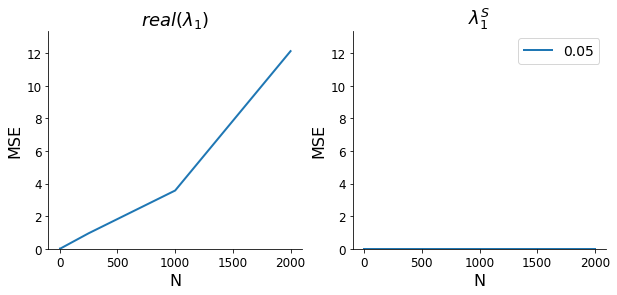

In [20]:
labels = [r'$real(\lambda_1)$', r'$\lambda_1^S$']
gs = [0.05]
K = 1
fig, axs = plt.subplots(1,2,figsize=(10,4))
all_mses = []
all_diffs = []
for g in gs:
    W_eigs_np = get_W_eigs_full_np(g, K, feed_noise=True)
    W_eigs_tf = get_W_eigs_full_tf(g, K, feed_noise=True)

    M = 10
    Ns = [2, 5,  250, 1000, 2000]
    mses = []
    diffs = []
    for N in Ns:
        print("g = %.2f, N=%d\r" % (g, N), end="")
        diff = compare_np_tf(M, N, K, W_eigs_np, W_eigs_tf, full=True)
        mses.append(np.mean(np.square(diff), axis=0))
        diffs.append(diff)
    mses = np.array(mses)
    diffs = np.array(diffs)
       
    for i in range(2):
        axs[i].plot(Ns, mses[:,i], label=g)
    
    all_mses.append(mses)
    all_diffs.append(diffs)

all_mses = np.array(all_mses)
all_diffs = np.array(all_diffs)

max_mse = np.max(np.array(all_mses))
        
for i in range(2):
    axs[i].set_xlabel('N')
    axs[i].set_ylabel('MSE')
    axs[i].set_title(labels[i])
    axs[i].set_ylim([0,1.1*max_mse])

plt.legend()
plt.show()


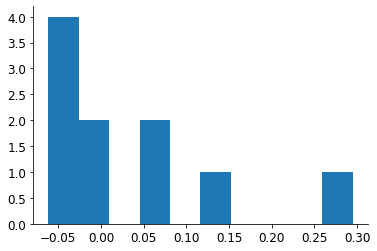

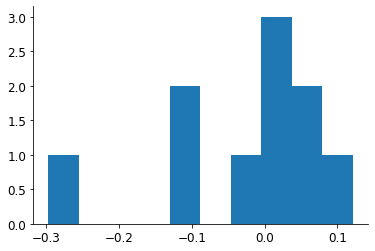

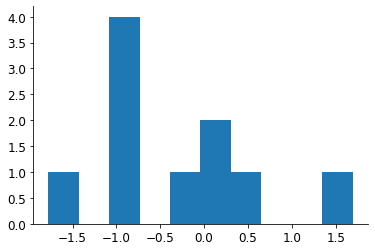

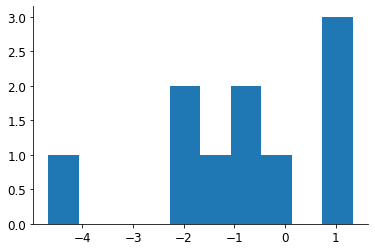

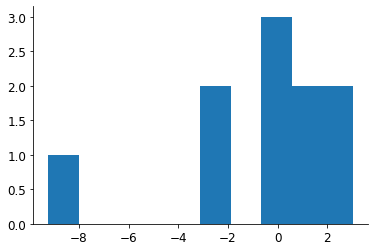

In [22]:
for i, N in enumerate(Ns):
    plt.figure()
    plt.hist(all_diffs[0,i,:,0])
    plt.show()

In [32]:
K = 1
W_eigs_tf = get_W_eigs_full_tf(0.05, K, feed_noise=True)
M = 10
N = 25
U = np.random.uniform(-1., 1., (M,N,2)).astype(np.float32)
V = np.random.uniform(-1., 1., (M,N,2)).astype(np.float32)
noise = np.random.normal(0., 1., (M,K,N,N))
eigs_tf = W_eigs_tf(U, V, noise=noise)
print(eigs_tf)
eigs_np = np.array([W_eigs_np(U[m], V[m], noise=noise[m]) for m in range(M)])
print(eigs_np)

J_eig_realmax tf.Tensor(
[ 0.8581506  -1.509088    3.3477535   2.6477027  -0.23859634  1.7987142
  2.3063633   0.5176816   1.153028    0.33300063], shape=(10,), dtype=float32)
tf.Tensor(
[[8.58150601e-01 5.34683752e+00 1.28271848e-01 1.47981586e+01]
 [5.00000007e-02 4.03060436e+00 2.02499986e-01 6.40395832e+00]
 [3.34775352e+00 5.98717928e+00 8.10970020e+00 2.01347771e+01]
 [2.64770269e+00 5.08946133e+00 4.61262703e+00 1.28842325e+01]
 [5.00000007e-02 3.87619948e+00 2.02499986e-01 5.64632416e+00]
 [1.79871416e+00 6.39162970e+00 1.68665850e+00 2.39280415e+01]
 [2.30636334e+00 5.89609957e+00 3.26294851e+00 1.93256912e+01]
 [5.17681599e-01 4.29571629e+00 3.12638935e-04 7.81602955e+00]
 [1.15302801e+00 5.70304918e+00 4.26445574e-01 1.76656227e+01]
 [3.33000630e-01 5.14911747e+00 2.78887898e-02 1.33160582e+01]], shape=(10, 4), dtype=float32)
[[0.458435   5.34683525]
 [0.40185689 4.03060398]
 [3.23039365 5.98717509]
 [2.6978956  5.08945681]
 [0.92924842 3.87619598]
 [1.92494431 6.39163047]
 

In [33]:
J = np.matmul(U, np.transpose(V, [0,2,1]))
J = J + g*np.random.normal(0., 1., J.shape)

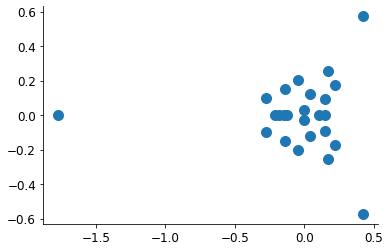

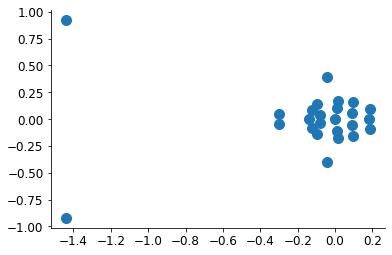

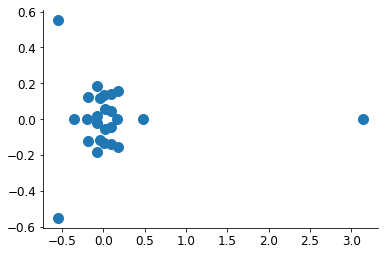

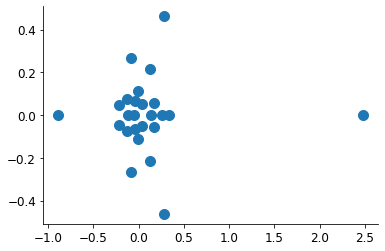

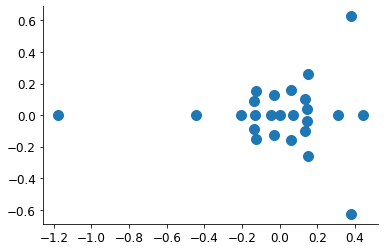

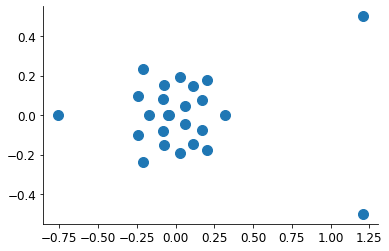

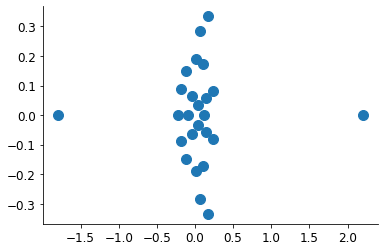

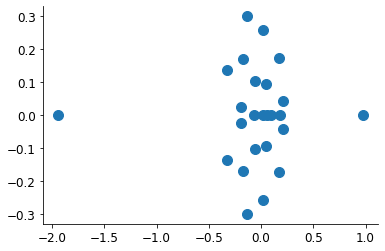

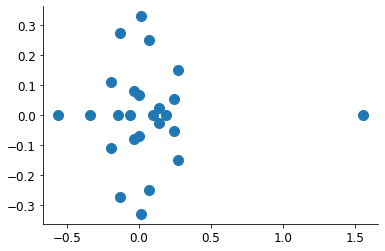

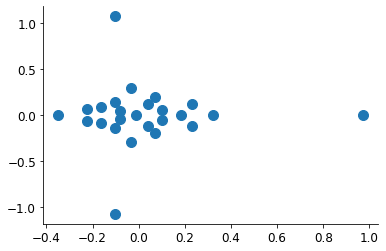

In [38]:
for _J in J:
    w,v = np.linalg.eig(_J)
    real_w = np.real(w)
    imag_w = np.imag(w)
    plt.figure()
    plt.scatter(real_w, imag_w)
    plt.show()